In [54]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from shutil import copyfile
# from notebooks.utils import plot_images, plot_matches, add_frame
from hfnet.models import get_model  

In [55]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from shutil import copyfile
import os
import sys
import collections
import struct
import argparse
import logging
import torch
import json
from hfnet.settings import EXPER_PATH
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
tf.contrib.resampler  # import C++ op
%load_ext autoreload
%autoreload 2
%matplotlib inline

# from notebooks.utils import plot_images, plot_matches, add_frame

from hfnet.models import get_model  
import Image_functions
import  jsonparser
from hloc.utils import viz
from hloc import  visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# send the path to the image directory and get the path to all the images in it
def image_directory_parser(path, viewer=True, number= 4):    
    globs=['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG']
    ## can also use sufix instead of with method
    image_path = []
    for g in globs:
        image_path += list(path.glob("**/"+g))
    print(len(image_path))
    if viewer:
        nrows = number
        ncols = number
        fig = plt.gcf()
        fig.set_size_inches(ncols*4, ncols*4)
        for i in range(2*number):
            sp = plt.subplot(nrows, ncols, i + 1)
            sp.axis('Off') # Don't show axes (or gridlines)
            img = mpimg.imread((image_path[i]))
            plt.imshow(img)
        plt.show()
    return image_path

In [57]:
path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/skip3')

1291


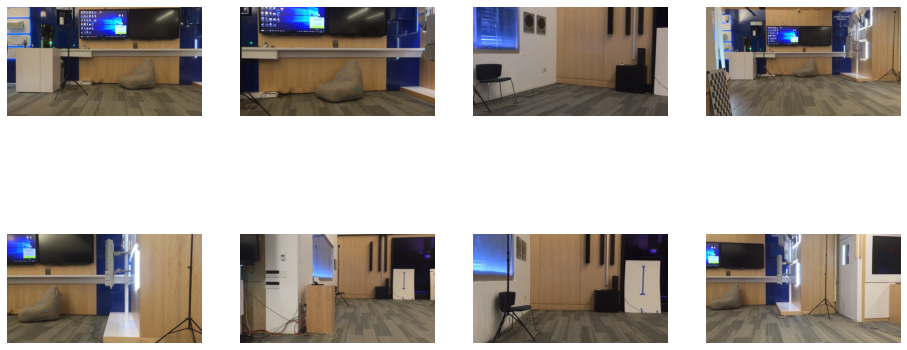

In [58]:
image_path = image_directory_parser(path_to_images_for_map, viewer=True, number = 4) 


In [59]:
path_to_json = Path('/home/Hierarchical-Localization/datasets/iPhoSil210228T2PoseData')

In [60]:
#JSS
## what format are the rotation is in?
## right now parsing it and keeping it 
import numpy as np
import json 
from pathlib import Path
root ='/home/Hierarchical-Localization/datasets/iPhoSil210228T2PoseData'# need to pass in as an argument 

image_dir = root+"/imageFileNamesValid.json"
translation_dir = root+"/tvecsU.json"
rotation_dir = root+"/rvecsU.json"

with open(image_dir) as f:
    image_names = json.load(f)
with open(translation_dir) as f:
    translation_values = json.load(f)
with open(rotation_dir) as f:
    rotation_values = json.load(f)


def parser():
    names_trans_rot = {}
    j =0 
    root ='/home/Hierarchical-Localization/datasets/iPhoSil210228T2PoseData'# need to pass in as an argument 

    image_dir = root+"/imageFileNamesUseful.json"
    translation_dir = root+"/tvecsU.json"
    rotation_dir = root+"/rvecsU.json"
    current_skip = 0
    from_useful = {}
    skip = 3
    with open(image_dir) as f:
        image_names = json.load(f)
#         print(np.shape(image_names))
    with open(translation_dir) as f:
        translation_values = json.load(f)
#         print(np.shape(translation_values))
    with open(rotation_dir) as f:
        rotation_values = json.load(f)
#         print(np.shape(rotation_values))
    
    for i in tqdm(range(len(image_names))):
        name = (image_names[i]).split("/")[7]
#         print(np.shape(translation_values[0]))
#         print(np.shape(translation_values[1]))
        
#         print(np.shape(translation_values[2]))
        

        tvec = [translation_values[0][j], translation_values[1][j], translation_values[2][j]]
        rvec = [rotation_values[0][j], rotation_values[1][j],rotation_values[2][j]]
        names_trans_rot[name]= {"tvec":tvec, "rvec":rvec}
        j = j+1
        if current_skip<skip:
            current_skip+=1
            continue
        current_skip = 0
        from_useful[name]= {"tvecs": tvec, "rvecs": rvec}
            
    print(len(names_trans_rot))
    return names_trans_rot, from_useful

In [61]:
names_trans_rot, from_useful = parser()

100%|██████████| 5166/5166 [00:00<00:00, 236889.12it/s]

5166


In [62]:
# image dictionary creator gives image, its name and index as dictionary
def dictionary_of_images(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[i] = {"image":image_array, "name": image_path[i].name, "number": i}
    return image_dict

In [63]:
image_dict = dictionary_of_images(image_path)
print(len(image_dict))

1291it [00:12, 105.41it/s]

1291


In [11]:

# this finds the global matrix and create the h5 file for global features
# also return a dictionary with index, image name and the descriptor associated
def global_dict_matrix_and_H5_map(config, image_dict):
    predictions_dict = {}
    global_feature_path = (config["output"])/"global_features.h5"
    global_feature_file = h5py.File(str(global_feature_path), 'w')
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
            grp = global_feature_file.create_group(data['name'])
            grp.create_dataset('global_descriptor', data=predictions['global_descriptor'])
        global_feature_file.close()
    return predictions_dict, global_matrix

In [12]:
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)

In [13]:
# Writing the .txt file. 
# this funtion creates the .txt for global matches
# similar matches are automatically removed by matcher featurea 
##hence dont worry about it :)
def text_file_for_global_matches(global_feature_dict, global_feature_matrix, path, number): 
    predictions_dict_matches = {}
    for i in tqdm(range(len(global_feature_dict))):
        current_descriptor = global_feature_matrix[i, :]
        neighbours = compute_distance(current_descriptor, global_feature_matrix)
        predictions_dict_matches[i] = ((np.argsort(neighbours))[:number])[1 :]
    #first writing the file
    output_file_txt = path/"global_feature.txt"
    with open(output_file_txt, 'w') as f:
        for i in tqdm(range(len(predictions_dict_matches))):
            current_image_name = global_feature_dict[i]["name"]
            current_image_matches = predictions_dict_matches[i]
            string_list = []
            for j in range(len(current_image_matches)):
                    if i == 0 and j ==0:
                        making_a_string = current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    
                    else: 
                        making_a_string = "\n" + current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    f.write(making_a_string)

In [14]:
## here set the path for output 
#"""sfm_T3_pba""" 
output_path = Path("/home/Hierarchical-Localization/outputs/skip3_datanew")
output_path.mkdir(exist_ok =True, parents= True)

In [15]:
# here setting the path for weights saved for netVLAD
checkpoint_path = Path("/home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white")
# here config for global
config_global = {'output':output_path, 'checkpoint_path':checkpoint_path, 'data': {'name': 'aachen', 'load_db': False, 'load_queries': True, 'resize_max': 960}, 'model': {'name': 'netvlad_original', 'local_descriptor_layer': 'conv3_3', 'image_channels': 1}, 'weights': 'vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white'}

In [16]:
# calling the function for global descriptor
global_dict_map, global_matrix = global_dict_matrix_and_H5_map(config_global, image_dict)

W0309 23:34:03.013851 140079845001024 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:104: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0309 23:34:03.018351 140079845001024 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0309 23:34:03.019640 140079845001024 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0309 23:34:03.021179 140079845001024 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:275: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0309 23:34:03.025883 140079845001024 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/h

In [17]:
# creating the txt file for matches
# here the last argument is the number of global matches you want to find
text_file_for_global_matches(global_dict_map, global_matrix,output_path,10)

100%|██████████| 1291/1291 [00:00<00:00, 65228.11it/s]


In [18]:
%load_ext autoreload
%autoreload 2
from hloc import extract_features, match_features, reconstruction, visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:

## this is the configuration for finding local features
## the name of the output file will be the 
### key for output in feature_conf_superpoint 

feature_conf_superpoint = {'output': 'features_superpoint', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}

In [22]:
## finds the local features and stores it as a h5 file
extract_features.main(feature_conf_superpoint,path_to_images_for_map,output_path)

I0309 23:36:47.113256 140079845001024 extract_features.py:123] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'features_superpoint',
 'preprocessing': {'grayscale': True, 'resize_max': 960}}


Loaded SuperPoint model


I0309 23:36:50.365649 140079845001024 extract_features.py:81] Found 1291 images in root /home/Hierarchical-Localization/datasets/skip3.
100%|██████████| 1291/1291 [00:13<00:00, 98.08it/s] 
I0309 23:37:03.561684 140079845001024 extract_features.py:160] Finished exporting features.


In [23]:

## this is the configuration for matching and it also gives a h5 filw
matcher_conf = {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features = feature_conf_superpoint['output']

In [24]:
## this is the name of the file .txt for global matches
sfm_pairs = output_path/"global_feature.txt"

In [25]:
match_features.main(matcher_conf, sfm_pairs, features, output_path)

I0309 23:37:21.556267 140079845001024 match_features.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
  0%|          | 2/11619 [00:00<12:21, 15.66it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 11619/11619 [06:22<00:00, 30.40it/s]
I0309 23:43:44.067403 140079845001024 match_features.py:113] Finished exporting matches.


In [26]:
## this is the directory where the sfm model will be saved
sfm_dir = output_path/'sfm_superpoint+superglue'

In [27]:
feature_file = output_path/'features_superpoint.h5'
match_file = output_path/'features_superpoint_matches-superglue_global_feature.h5'

In [28]:
## This creates the SFM model
reconstruction.main(
    sfm_dir,
    path_to_images_for_map,
    sfm_pairs,
    feature_file,
    match_file, pba=True)

I0309 23:43:44.231505 140079845001024 reconstruction.py:16] Creating an empty database...
I0309 23:43:44.259760 140079845001024 reconstruction.py:25] Importing images into the database...
I0309 23:43:55.261752 140079845001024 triangulation.py:41] Importing features into the database...
100%|██████████| 1291/1291 [00:00<00:00, 2074.27it/s]
I0309 23:43:55.932577 140079845001024 triangulation.py:59] Importing matches into the database...
100%|██████████| 11619/11619 [00:03<00:00, 3153.58it/s]
I0309 23:43:59.813001 140079845001024 triangulation.py:100] Performing geometric verification of the matches...
I0309 23:44:02.327396 140079845001024 reconstruction.py:68] Running the 3D reconstruction...
I0309 23:44:02.330300 140079845001024 reconstruction.py:86] colmap mapper --database_path /home/Hierarchical-Localization/outputs/skip3_datanew/sfm_superpoint+superglue/database.db --image_path /home/Hierarchical-Localization/datasets/skip3 --output_path /home/Hierarchical-Localization/outputs/skip3

In [31]:
def txt_file_for_geo_registration(output_path, using, number_of_images):
    file_name = 'output_world_file.txt'
    file_path = output_path/file_name
    using_list_keys = list(using.keys())
    with open(file_path, 'w') as f:    
        for i in range(number_of_images):
            image_name = using_list_keys[i]
            tvec = using[image_name]['tvecs']
            if i ==0:
                string = image_name+ " "+ str(tvec[0])+" "+ str(tvec[1])+" "+str(tvec[2])
            else:
                string = "\n" + image_name+ " "+str(tvec[0])+" "+ str(tvec[1])+" "+str(tvec[2])
            f.write(string)

In [32]:
txt_file_for_geo_registration(output_path, from_useful, 500)

In [33]:
sfm_dir = output_path/'sfm_superpoint+superglue'
geo_registration_dir = sfm_dir/"geo_registered_model"
geo_registration_dir.mkdir(exist_ok = True)

import subprocess
cmd = ["colmap", "model_aligner",
       '--input_path', str(sfm_dir/"models"/"0"),
       '--output_path', str(geo_registration_dir),
       '--ref_images_path', str(output_path/'output_world_file.txt'),
       '--robust_alignment_max_error', str(20)]

ret = subprocess.call(cmd)
print (ret)
print("should print 0 if succesfull")


0
should print 0 if succesfull


In [38]:
## find the error within itself
## these funtion were copied from utilies and were made change according to the requierement
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)
def read_images_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        for image_index in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi")
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":   # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8,
                                           format_char_sequence="Q")[0]
            x_y_id_s = read_next_bytes(fid, num_bytes=24*num_points2D,
                                       format_char_sequence="ddq"*num_points2D)
            xys = np.column_stack([tuple(map(float, x_y_id_s[0::3])),
                                   tuple(map(float, x_y_id_s[1::3]))])
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_name] = Image(
                id=image_id, qvec=qvec, tvec=tvec,
                camera_id=camera_id, name=image_name,
                xys=xys, point3D_ids=point3D_ids)
    return images
def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])
def colmap_to_global(_tvec, _qvec):
    return -np.matmul(qvec2rotmat(_qvec).transpose(), _tvec)
def global_and_colmap(name, read_images_binary, using):
    tvec = using[name]['tvecs']
    rvec = using[name]['rvecs']
    tvec_colmap = read_images_binary[name][2]
    rvec_colmap = read_images_binary[name][1]
    CtG= colmap_to_global(tvec_colmap, rvec_colmap)
    return tvec, CtG
def error(tvec, CtG):
    return np.linalg.norm(tvec-CtG)

In [39]:
image_bin_path = geo_registration_dir/"images.bin"
## this gives the pose of every image in the geo registered map
ReadImagesBinary = read_images_binary(image_bin_path)

In [40]:
## this will create a .txt file with the errors  for GT and the map 
def within_itself(using, ReadImagesBinary, path):
    list_of_registered = list(ReadImagesBinary.keys())
    file_name = 'with_itself_map_and_GT.txt'
    error_list = []
    with open(path/file_name, 'w') as f:        
        for i  in range(len(list_of_registered)):
            tvec, CtG = global_and_colmap(list_of_registered[i], ReadImagesBinary, using)
            err = error(tvec, CtG)
            error_list.append(err)
            if i == 0:
                string = list_of_registered[i]+ " " + str(tvec) + " " +str(CtG) + " " + str(err)
            else:
                string ='\n'+ list_of_registered[i]+ " " + str(tvec) + " " +str(CtG) + " " + str(err)
            f.write(string)
        error_list = np.asarray(error_list,  dtype=np.float32)
        string = '\n'+"The median error is "+ str(np.median(error_list))
        f.write(string)
        string = '\n'+"The mean error is "+ str(np.mean(error_list))
        f.write(string)
        string = '\n'+"The max error is "+ str(np.max(error_list))
        f.write(string)

In [41]:
within_itself(from_useful, ReadImagesBinary, output_path)

In [42]:
#JSS
## what format are the rotation is in?
## right now parsing it and keeping it 
import numpy as np
import json 
from pathlib import Path
root ='/home/Hierarchical-Localization/datasets/iPhoSil210228T2PoseData'# need to pass in as an argument 

image_dir = root+"/imageFileNamesValid.json"
translation_dir = root+"/tvecsU.json"
rotation_dir = root+"/rvecsU.json"

with open(image_dir) as f:
    image_names = json.load(f)
with open(translation_dir) as f:
    translation_values = json.load(f)
with open(rotation_dir) as f:
    rotation_values = json.load(f)


def parser_query():
    names_trans_rot = {}
    j =0 
    root ='/home/Hierarchical-Localization/datasets/iPhoSil210228T2PoseData'# need to pass in as an argument 

    image_dir = root+"/imageFileNamesUseful.json"
    translation_dir = root+"/tvecsU.json"
    rotation_dir = root+"/rvecsU.json"
    current_skip = 0
    from_useful = {}
    skip = 4
    with open(image_dir) as f:
        image_names = json.load(f)
#         print(np.shape(image_names))
    with open(translation_dir) as f:
        translation_values = json.load(f)
#         print(np.shape(translation_values))
    with open(rotation_dir) as f:
        rotation_values = json.load(f)
#         print(np.shape(rotation_values))
    
    for i in tqdm(range(len(image_names))):
        name = (image_names[i]).split("/")[7]
#         print(np.shape(translation_values[0]))
#         print(np.shape(translation_values[1]))
        
#         print(np.shape(translation_values[2]))
        

        tvec = [translation_values[0][j], translation_values[1][j], translation_values[2][j]]
        rvec = [rotation_values[0][j], rotation_values[1][j],rotation_values[2][j]]
        names_trans_rot[name]= {"tvec":tvec, "rvec":rvec}
        j = j+1
        if current_skip<skip:
            current_skip+=1
            continue
        current_skip = 0
        from_useful[name]= {"tvecs": tvec, "rvecs": rvec}
            
    print(len(names_trans_rot))
    return names_trans_rot, from_useful

In [43]:
_, from_useful_query = parser_query()

100%|██████████| 5166/5166 [00:00<00:00, 24422.79it/s]

5166


In [50]:
len(from_useful_query)

1033

In [51]:
# def dictionary_of_images(image_path, using, path_to_images_for_map):
#     list_of_image = list(using.keys())
#     image_dict ={}
#     to_save = (path_to_images_for_map.parent)/"skip4"
#     to_save.mkdir()
#     index = 0
#     for i,j in tqdm(enumerate(image_path)):
#         if str(j.name) in list_of_image:
#             image_array = cv2.imread(str(j))
#     #         print(image_path[i].name)
#             image_to_save = to_save/j.name
#             copyfile(j,image_to_save)
#             image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
#             image_dict[index] = {"image":image_array, "name": image_path[i].name, "number": index}
#             index+=1
#     return image_dict

5166


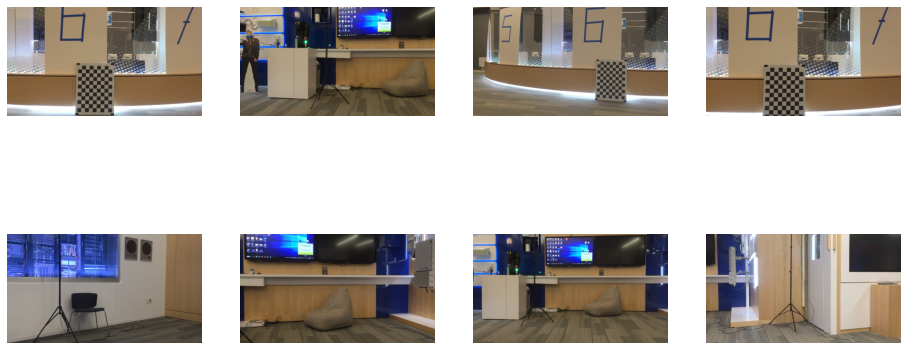

5166it [00:10, 469.92it/s]


{0: {'image': array([[[ 64,  57,  54],
          [ 70,  61,  57],
          [ 74,  65,  58],
          ...,
          [148, 129, 110],
          [148, 129, 110],
          [148, 129, 110]],
  
         [[ 80,  74,  68],
          [ 71,  63,  56],
          [ 68,  59,  52],
          ...,
          [148, 129, 110],
          [148, 129, 110],
          [148, 129, 110]],
  
         [[ 99,  91,  81],
          [ 91,  83,  73],
          [ 83,  75,  65],
          ...,
          [148, 129, 110],
          [148, 129, 110],
          [149, 130, 112]],
  
         ...,
  
         [[ 89,  82,  58],
          [ 87,  81,  57],
          [ 97,  90,  66],
          ...,
          [112,  89,  62],
          [105,  82,  55],
          [108,  86,  59]],
  
         [[ 93,  88,  66],
          [ 98,  94,  72],
          [ 92,  87,  65],
          ...,
          [107,  84,  60],
          [ 98,  75,  48],
          [107,  84,  58]],
  
         [[ 87,  85,  65],
          [ 86,  83,  64],
          [ 

In [52]:
# path_to_images_for_map_ori = Path('/home/Hierarchical-Localization/datasets/iPhoSil210228T2LowResUseful')
# image_path_ori = image_directory_parser(path_to_images_for_map_ori, viewer=True, number = 4) 

# dictionary_of_images(image_path_ori, from_useful_query, path_to_images_for_map_ori)

1033


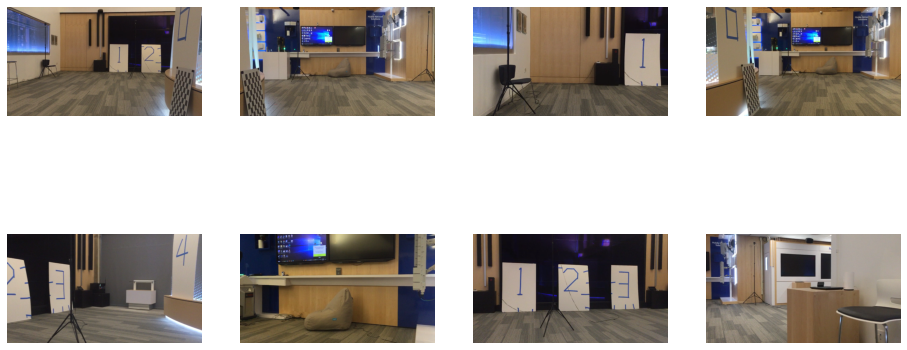

1033it [00:09, 112.97it/s]


In [64]:
## send the path to query images
path_to_query = Path("/home/Hierarchical-Localization/datasets/skip4")
## this will create a list with all the image path in it
image_path_query = image_directory_parser(path_to_query, viewer=True, number = 4)
# dictionary_of_images creator gives image, its name and index as dictionary
image_dict_query = dictionary_of_images(image_path_query)

In [65]:
## will find the global descriptor for query images

def global_dict_matrix_query(config, image_dict):
    predictions_dict = {}
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
    return predictions_dict, global_matrix

In [66]:
# calling the above function 
predicitons_dict_query, global_matric_query = global_dict_matrix_query(config_global, image_dict_query)

I0310 00:41:06.103181 140079845001024 base_model.py:429] Restoring variables: 
	vgg16_netvlad_pca/WPCA/bias
	vgg16_netvlad_pca/WPCA/kernel
	vgg16_netvlad_pca/assignment/kernel
	vgg16_netvlad_pca/average_rgb
	vgg16_netvlad_pca/cluster_centers
	vgg16_netvlad_pca/conv1_1/bias
	vgg16_netvlad_pca/conv1_1/kernel
	vgg16_netvlad_pca/conv1_2/bias
	vgg16_netvlad_pca/conv1_2/kernel
	vgg16_netvlad_pca/conv2_1/bias
	vgg16_netvlad_pca/conv2_1/kernel
	vgg16_netvlad_pca/conv2_2/bias
	vgg16_netvlad_pca/conv2_2/kernel
	vgg16_netvlad_pca/conv3_1/bias
	vgg16_netvlad_pca/conv3_1/kernel
	vgg16_netvlad_pca/conv3_2/bias
	vgg16_netvlad_pca/conv3_2/kernel
	vgg16_netvlad_pca/conv3_3/bias
	vgg16_netvlad_pca/conv3_3/kernel
	vgg16_netvlad_pca/conv4_1/bias
	vgg16_netvlad_pca/conv4_1/kernel
	vgg16_netvlad_pca/conv4_2/bias
	vgg16_netvlad_pca/conv4_2/kernel
	vgg16_netvlad_pca/conv4_3/bias
	vgg16_netvlad_pca/conv4_3/kernel
	vgg16_netvlad_pca/conv5_1/bias
	vgg16_netvlad_pca/conv5_1/kernel
	vgg16_netvlad_pca/conv5_2/bias


In [67]:
## creates the global matches txt file for query with map 
def query_global_txt_file_creator(image_dict_query, image_dict_map, global_matrix, predictions_dict_query, path, file_name, number):
    with open(path/file_name, 'w') as f:
        for i in tqdm(range(len(predictions_dict_query))):
            current_descriptor = predictions_dict_query[i]["global_descriptor"]
            neighbours = compute_distance(current_descriptor, global_matrix)
            global_matches = ((np.argsort(neighbours))[:number])
            for j in range(len(global_matches)):
                if i == 0 and j ==0:
                    string = image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                else:
                    string = "\n"+ image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                f.write(string) 

In [68]:
## callling the above funtion 
## take in input as the dictionary of map image
##dict of query images
## global matrix of map image
## global descriptor image dict of query images
global_file_txt = "global_image_query.txt"
query_global_txt_file_creator(image_dict_query, image_dict, global_matrix, predicitons_dict_query, output_path, global_file_txt, 10)

100%|██████████| 1033/1033 [00:00<00:00, 3109.38it/s]


In [69]:
## local image conf for query images here the only different is output
feature_conf_superpoint_query = {'output': 'features_superpoint_query', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}

In [70]:
## calling the local feature extractor function 
extract_features.main(feature_conf_superpoint_query,path_to_query,output_path)

I0310 00:41:54.581293 140079845001024 extract_features.py:123] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'features_superpoint_query',
 'preprocessing': {'grayscale': True, 'resize_max': 960}}
I0310 00:41:54.641597 140079845001024 extract_features.py:81] Found 1033 images in root /home/Hierarchical-Localization/datasets/skip4.
  0%|          | 0/1033 [00:00<?, ?it/s]

Loaded SuperPoint model


100%|██████████| 1033/1033 [00:10<00:00, 98.40it/s] 
I0310 00:42:05.165893 140079845001024 extract_features.py:160] Finished exporting features.


In [76]:
## setting the configuration for matches query (superglue)
matcher_conf_query = {'output': 'matches-superglue_query', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features_query = feature_conf_superpoint_query['output']
loc_pairs = output_path/global_file_txt

In [77]:
## this matcheer is differnt as it needs feature both for the query imags and map images
from hloc import feature_matcher_map_query
feature_matcher_map_query.main(matcher_conf_query, loc_pairs, features, output_path, features_query, self = True)

I0310 01:04:14.071145 140079845001024 feature_matcher_map_query.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue_query'}
I0310 01:04:14.073904 140079845001024 feature_matcher_map_query.py:50] Using query_features features_superpoint_query
  0%|          | 2/10330 [00:00<10:31, 16.36it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 10330/10330 [09:35<00:00, 17.96it/s]
I0310 01:13:49.591671 140079845001024 feature_matcher_map_query.py:128] Finished exporting matches.


In [78]:
## this creates a .txt file for queries and their camera intricsics
filename = "queries_choosen_with_intrinsics.txt"
with open(output_path/filename, 'w') as f:
    for i in range(len(image_path_query)):
        name = image_path_query[i].name
        if i ==0:
            string = str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
        else:
            string = "\n"+  str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
        f.write(string)

In [79]:
from hloc import localize_sfm

localize_sfm.main(geo_registration_dir,
                 output_path/"queries_choosen_with_intrinsics.txt",
                 loc_pairs,
                 output_path/'features_superpoint_query.h5',
                 output_path/'features_superpoint_matches-superglue_query_global_image_query.h5',
                 output_path/'results_query.txt',
                 covisibility_clustering=False)

I0310 01:14:10.349978 140079845001024 parsers.py:16] Importing 1033 queries in queries_choosen_with_intrinsics.txt
I0310 01:14:10.372322 140079845001024 localize_sfm.py:109] Reading 3D model...
I0310 01:14:11.389356 140079845001024 localize_sfm.py:123] Starting localization...
100%|██████████| 1033/1033 [01:20<00:00, 12.76it/s]
I0310 01:15:32.332005 140079845001024 localize_sfm.py:183] Localized 1033 / 1033 images.
I0310 01:15:32.333368 140079845001024 localize_sfm.py:184] Writing poses to /home/Hierarchical-Localization/outputs/skip3_datanew/results_query.txt...
I0310 01:15:32.355647 140079845001024 localize_sfm.py:194] Writing logs to /home/Hierarchical-Localization/outputs/skip3_datanew/results_query.txt_logs.pkl...
I0310 01:15:36.703943 140079845001024 localize_sfm.py:197] Done!


In [82]:
def file_creator_error(original_dict_json, file_name_read, file_name_write, path):
    list_of_registered = list(original_dict_json.keys())
    with open(path/file_name_read, 'r') as f:
        Lines = f.readlines()
    error_list = []
    with open(path/file_name_write, 'w') as f:
        for line in Lines:
            line = line.split()
            name = line[0]
            qvec = np.asarray(line[1:5], dtype=np.float32)
#             qvec = np.array([line[2], line[3], line[4], line[1]],dtype=np.float32)
            tvec = np.asarray(line[5:8], dtype=np.float32)
            tvec_world = colmap_to_global(tvec, qvec)
            tvec_ori = original_dict_json[name]["tvecs"]
            er =  error(tvec_world, tvec_ori)
            error_list.append(er)
            string = name + " "+ str(tvec_ori)+ " "+str(tvec_world)+ " " + str(er)+ "\n"
            f.write(string)
        error_list = np.asarray(error_list,  dtype=np.float32)
        string = "The median error is "+ str(np.median(error_list))+ '\n'
        f.write(string)
        string = "The mean error is "+ str(np.mean(error_list))+ '\n'
        f.write(string)
        string = "The max error is "+ str(np.max(error_list))
        f.write(string)

In [83]:
file_creator_error(from_useful_query,'results_query.txt', "results_query_error.txt", output_path)